<a href="https://colab.research.google.com/github/subbu521/EVA4/blob/master/S10/EVA_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')


In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np


train_transforms = AlbumentationTransforms(
    [ A.Rotate((-30.0, 30.0)),
      A.HorizontalFlip(),
      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      A.Cutout(num_holes=6)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



 bird  frog   dog  deer


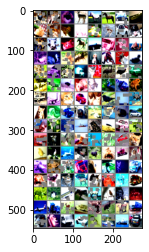

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import evamodel

net = evamodel.ResNet18()

In [0]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


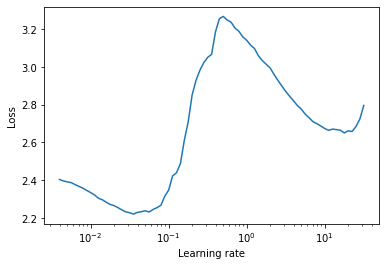

In [0]:
LR = lr_finder.history['lr'][0]

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [0]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test

model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    val = test(model, device, testloader)
    scheduler.step(val)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6215791702270508 Batch_id=390 Accuracy=36.46: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5580, Accuracy: 4420/10000 (44.20%)

EPOCH: 1


Loss=1.1259548664093018 Batch_id=390 Accuracy=50.74: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4040, Accuracy: 5960/10000 (59.60%)

EPOCH: 2


Loss=0.9779671430587769 Batch_id=390 Accuracy=57.92: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3507, Accuracy: 6493/10000 (64.93%)

EPOCH: 3


Loss=1.2107996940612793 Batch_id=390 Accuracy=61.95: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3386, Accuracy: 6614/10000 (66.14%)

EPOCH: 4


Loss=0.9686474800109863 Batch_id=390 Accuracy=65.46: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2610, Accuracy: 7390/10000 (73.90%)

EPOCH: 5


Loss=0.888461709022522 Batch_id=390 Accuracy=68.27: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2528, Accuracy: 7472/10000 (74.72%)

EPOCH: 6


Loss=0.9402605295181274 Batch_id=390 Accuracy=70.60: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2517, Accuracy: 7483/10000 (74.83%)

EPOCH: 7


Loss=0.7279146313667297 Batch_id=390 Accuracy=72.32: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2264, Accuracy: 7736/10000 (77.36%)

EPOCH: 8


Loss=0.583334743976593 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2147, Accuracy: 7853/10000 (78.53%)

EPOCH: 9


Loss=0.5802017450332642 Batch_id=390 Accuracy=75.31: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2069, Accuracy: 7931/10000 (79.31%)

EPOCH: 10


Loss=0.6242496967315674 Batch_id=390 Accuracy=76.74: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1890, Accuracy: 8110/10000 (81.10%)

EPOCH: 11


Loss=0.526767909526825 Batch_id=390 Accuracy=77.85: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1984, Accuracy: 8016/10000 (80.16%)

EPOCH: 12


Loss=0.5438557863235474 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1843, Accuracy: 8157/10000 (81.57%)

EPOCH: 13


Loss=0.7782803177833557 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1745, Accuracy: 8255/10000 (82.55%)

EPOCH: 14


Loss=0.5095304846763611 Batch_id=390 Accuracy=80.09: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1812, Accuracy: 8188/10000 (81.88%)

EPOCH: 15


Loss=0.5188695192337036 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1837, Accuracy: 8163/10000 (81.63%)

EPOCH: 16


Loss=0.43418455123901367 Batch_id=390 Accuracy=81.80: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1742, Accuracy: 8258/10000 (82.58%)

EPOCH: 17


Loss=0.6714116334915161 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1808, Accuracy: 8192/10000 (81.92%)

EPOCH: 18


Loss=0.4902198314666748 Batch_id=390 Accuracy=83.08: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1754, Accuracy: 8246/10000 (82.46%)

EPOCH: 19


Loss=0.4832676947116852 Batch_id=390 Accuracy=83.30: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1574, Accuracy: 8426/10000 (84.26%)

EPOCH: 20


Loss=0.365492045879364 Batch_id=390 Accuracy=83.88: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1609, Accuracy: 8391/10000 (83.91%)

EPOCH: 21


Loss=0.45581722259521484 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1630, Accuracy: 8370/10000 (83.70%)

EPOCH: 22


Loss=0.4216884672641754 Batch_id=390 Accuracy=84.92: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1588, Accuracy: 8412/10000 (84.12%)

EPOCH: 23


Loss=0.3954678177833557 Batch_id=390 Accuracy=85.54: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1647, Accuracy: 8353/10000 (83.53%)

EPOCH: 24


Loss=0.4386119246482849 Batch_id=390 Accuracy=85.68: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1529, Accuracy: 8471/10000 (84.71%)

EPOCH: 25


Loss=0.4490430951118469 Batch_id=390 Accuracy=85.86: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1443, Accuracy: 8557/10000 (85.57%)

EPOCH: 26


Loss=0.4075136184692383 Batch_id=390 Accuracy=86.40: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1523, Accuracy: 8477/10000 (84.77%)

EPOCH: 27


Loss=0.4662485122680664 Batch_id=390 Accuracy=86.68: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1364, Accuracy: 8636/10000 (86.36%)

EPOCH: 28


Loss=0.23134860396385193 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1479, Accuracy: 8521/10000 (85.21%)

EPOCH: 29


Loss=0.4265066683292389 Batch_id=390 Accuracy=87.54: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1324, Accuracy: 8676/10000 (86.76%)

EPOCH: 30


Loss=0.38649266958236694 Batch_id=390 Accuracy=87.80: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1392, Accuracy: 8608/10000 (86.08%)

EPOCH: 31


Loss=0.19725514948368073 Batch_id=390 Accuracy=88.31: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1309, Accuracy: 8691/10000 (86.91%)

EPOCH: 32


Loss=0.21355457603931427 Batch_id=390 Accuracy=88.64: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1289, Accuracy: 8711/10000 (87.11%)

EPOCH: 33


Loss=0.3956918716430664 Batch_id=215 Accuracy=88.99:  55%|█████▌    | 216/391 [01:48<01:27,  1.99it/s]

In [0]:
from evascheduler import draw_graph
draw_graph()

In [0]:
model_save_name = 'model.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [0]:
model_save_name = 'model.pt'
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

In [0]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


In [0]:
import grad_cam as gradcamAbs

In [0]:
config = dict(model_type='resnet', arch=model, layer_name='layer4')
means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [0]:
gradcam_images, pred_results = gcam.applyOnImages(dataloader=testloader, num_of_images=5)

In [0]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result")